α_D central train point: ('1.1000', '2.7500')
[ 46  10 204  84 184 195 171 208  93  48 121 155   9   7   6 122  86 189
  38 152 188  92 198  97  76 158 211 199   5  55  67  96 113 133 187  71
 149  70  47  61 127 135 162  95 160 130 103 205  58  81 144 161   2 129
 126 101  69  64 111 221 194  12 168 128  53 148  42  32  65 141 106  89
 124 146  16  50 147   8  40 104  90 119 183 203 108 190 213  31 140 105
  79  62 157 185 217 167 200 210 137 176  49 220  63  82 180 192 219   0
 218 115 142  19 209 107  74  36  41 186 216 173  33 110 182  35 165  20
 172 201 164 150  39  52 179 116 181 178 131  17  13 191 145 222  78 224
 223 215  11  15 151 177  87  88 132  26  29 174  60  85  14 139  98  77
  30 197 109 102  22  23 214  27  72 207 114  57  75  56  73 154  25  51
  94  54  45 163  80  28  43  37 136  83  66  24 120   4  68 175  99 138
 206   1 169 112 100  91 166  21 212 123 170 196 193 143  59 159 118  34
 117   3 156 134 202 125  18  44 153]
839.1048845448784 904.9703037081866 65.8

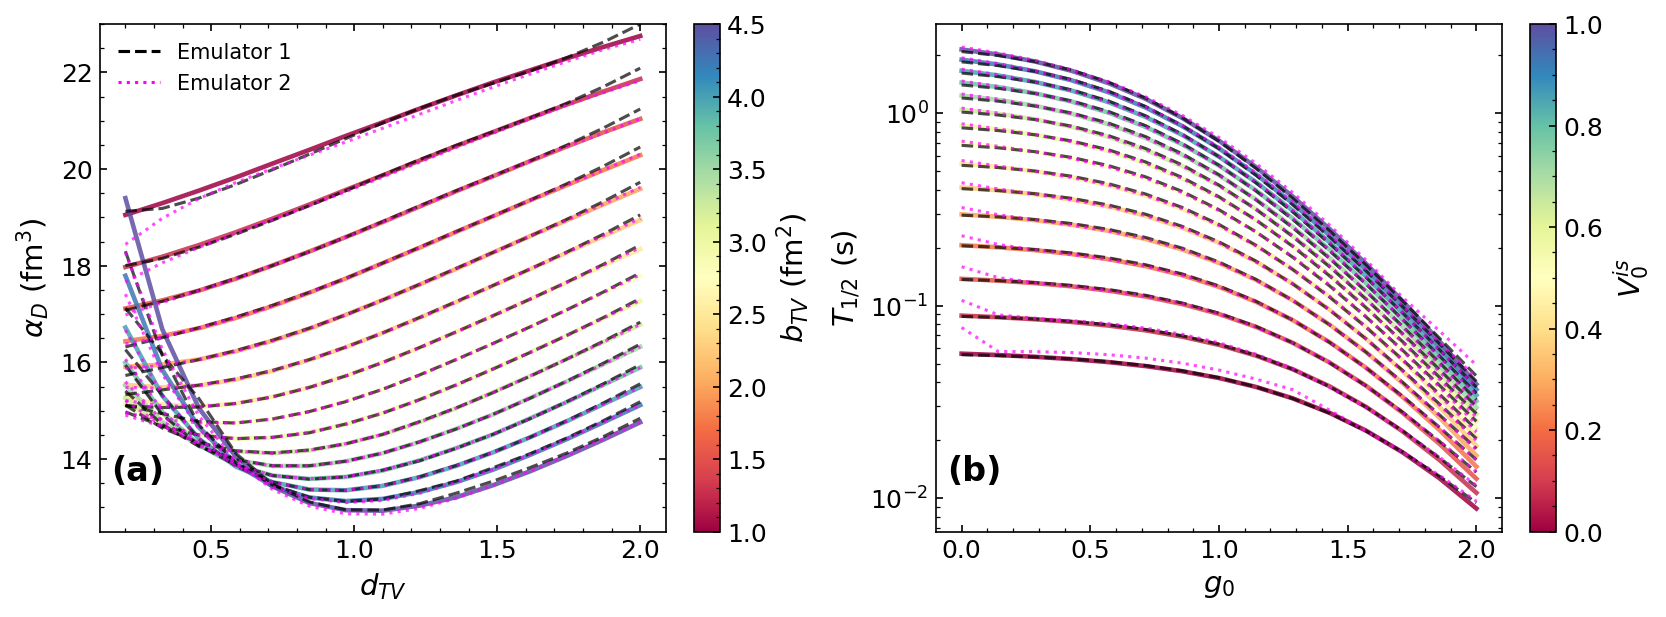

In [10]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

from __future__ import annotations
import os, re, sys
from pathlib import Path
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# --- Imports from your project layout ---
# add project root (parent of figs/) to import path if needed
sys.path.insert(0, str(Path("..").resolve()))
from Beta_decay import helper as beta_helper
from dipoles_exp_param import helper as dipole_helper
from numpy.polynomial.polynomial import Polynomial
import tensorflow as tf

# ---------------- rcParams (global styling) ----------------
plt.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 150,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})

# ====================== Utilities ======================

def parse_pairs_from_dir(directory: str | Path, regex: str, order=("alpha","beta")) -> list[tuple[float,float]]:
    """
    Scan directory, extract (alpha, beta) from filenames using a regex with two groups.
    `order` tells which group is alpha vs beta in the filename.
    """
    pat = re.compile(regex)
    pairs = []
    for fname in os.listdir(directory):
        m = pat.match(fname)
        if not m:
            continue
        g1, g2 = m.group(1), m.group(2)
        a, b = (float(g1), float(g2)) if order == ("alpha","beta") else (float(g2), float(g1))
        pairs.append((a, b))
    return pairs

def read_train_set_centroid(train_set_txt: str | Path) -> tuple[str,str]:
    """Return the *string* tuple of the training point closest to centroid (to match your helpers)."""
    pts = []
    with open(train_set_txt, "r") as f:
        for line in f:
            pts.append(tuple(map(str, line.strip().split(","))))
    arr = np.array(pts, dtype=float)
    centroid = arr.mean(axis=0)
    idx = np.argmin(np.linalg.norm(arr - centroid, axis=1))
    return pts[idx]

def to_emulator_array(points: list[tuple[float,float]], values: np.ndarray) -> np.ndarray:
    """Pack (alpha, beta, value) rows for plotting."""
    ab = np.array(points, float)
    z = np.asarray(values, float).reshape(-1, 1)
    return np.concatenate([ab[:, [0]], ab[:, [1]], z], axis=1)

def plot_family_by_constant_x(ax, table3: np.ndarray, cmap_name="Spectral", x_label="", y_label="", cbar_label=""):
    """
    Plot families of true curves for unique x (col 0), y is col 1, z is col 2.
    Returns (norm, sm, unique_x) so you can reuse the colorbar and uniques.
    """
    xvals = table3[:, 0]
    uniq = np.unique(xvals)
    cmap = plt.get_cmap(cmap_name)
    colors = [cmap(i / (len(uniq) - 1 if len(uniq) > 1 else 1)) for i in range(len(uniq))]

    for i, xv in enumerate(uniq):
        data = table3[table3[:, 0] == xv]
        data = data[data[:, 1].argsort()]
        ax.plot(data[:, 1], data[:, 2], color=colors[i], lw=2.2, alpha=0.85)

    norm = Normalize(vmin=float(np.min(xvals)), vmax=float(np.max(xvals)))
    sm = ScalarMappable(cmap=cmap_name, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label=cbar_label)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(cbar_label, fontsize=14)

    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    return norm, sm, uniq

def plot_family_by_constant_y(ax, table3: np.ndarray, cmap_name="Spectral", x_label="", y_label="", cbar_label=""):
    """
    Plot families grouped by constant y (col 1), x is col 0, z is col 2.
    Colorbar encodes unique y values.
    """
    yvals = table3[:, 1]
    uniq = np.unique(yvals)
    cmap = plt.get_cmap(cmap_name)
    colors = [cmap(i / (len(uniq) - 1 if len(uniq) > 1 else 1)) for i in range(len(uniq))]

    for i, yv in enumerate(uniq):
        data = table3[table3[:, 1] == yv]
        data = data[data[:, 0].argsort()]   # sweep over x (col 0)
        ax.plot(data[:, 0], data[:, 2], color=colors[i], lw=2.2, alpha=0.85)

    norm = Normalize(vmin=float(np.min(yvals)), vmax=float(np.max(yvals)))
    sm = ScalarMappable(cmap=cmap_name, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label=cbar_label)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(cbar_label, fontsize=14)

    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    return norm, sm, uniq


def overlay_emulator_lines(ax, emu: np.ndarray, group_by="y", color="k", ls="--", label=None):
    """
    Overlay emulator lines grouped by constant x or y.
    emu: (alpha, beta, value)
    """
    col = 1 if group_by == "y" else 0
    x_axis = 0 if group_by == "y" else 1  # when group_by=y, x-axis is alpha (col 0), else beta
    uniq = np.unique(emu[:, col])
    for u in uniq:
        data = emu[emu[:, col] == u]
        data = data[data[:, x_axis].argsort()]
        ax.plot(data[:, x_axis], data[:, 2], color=color, ls=ls, lw=1.5, alpha = 0.7)
    if label:
        ax.plot([], [], color=color, ls=ls, label=label)

# ====================== α_D panel ======================

def make_alphaD_panel(ax):
    # --- parse (alpha, beta) from filenames (strength: strength_(beta)_(alpha).out) ---
    strength_dir = Path("../dipoles_data_all/total_strength")
    # filename groups: (beta, alpha) → order tells us which is alpha/beta in result
    pairs = parse_pairs_from_dir(strength_dir, r"^strength_([0-9.]+)_([0-9.]+)\.out$", order=("beta","alpha"))
    # convert to canonical (alpha,beta) ordering
    pairs = [(f"{a:.4f}", f"{b:.4f}") for (a, b) in pairs]

    # --- training centroid (as strings for your helper) ---
    central_point = read_train_set_centroid("../dipoles_exp_param/train_set.txt")
    print("α_D central train point:", central_point)

    # --- true data via your helper ---
    _, alphaD_list = dipole_helper.data_table(pairs)
    alphaD_true = np.vstack(alphaD_list)  # columns: alpha, beta, α_D

    # --- Emulator (simple) ---
    n_simple = 10
    p_simple = np.loadtxt(f"../dipoles_exp_param/params_{n_simple}_only_alphaD.txt").astype(np.float32)
    alphaD_opt, alphaD_orig, _ = dipole_helper.plot_alphaD_simple(pairs, p_simple, n_simple, central_point)
    emu_simple = to_emulator_array(pairs, alphaD_opt)

    # --- Emulator 1 ---
    n1, retain1 = 15, 0.6
    p1 = np.loadtxt(f"../dipoles_exp_param/params_best_n{n1}_retain{retain1}.txt").astype(np.float32)
    alphaD_em1, _, _ = dipole_helper.plot_alphaD(pairs, p1, n1, central_point, retain1)
    emu1 = to_emulator_array(pairs, alphaD_em1)

    # --- plot: true families by constant alpha (x=alpha), x-axis is beta (col 1) ---
    plot_family_by_constant_x(
        ax,
        alphaD_true,
        cmap_name="Spectral",
        x_label=r"$d_{TV}$",
        y_label=r"$\alpha_D$ (fm$^3$)",
        cbar_label=r"$b_{TV}$ (fm$^{2}$)",
    )
    # overlay emulators: group by constant beta (vary alpha on x-axis) or vice versa
    overlay_emulator_lines(ax, emu1, group_by="y", color="k", ls="--", label="Emulator 1")
    overlay_emulator_lines(ax, emu_simple, group_by="y", color="magenta", ls=":", label="Emulator 2")
    

    ax.legend(frameon=False)
    ax.set_ylim(12.5, 23)

# ====================== Half-life panel ======================

def make_half_life_panel(ax):
    A, Z, g_A, nucnam = 80, 28, 1.2, "Ni_80"

    # phase-space polynomial
    poly = beta_helper.fit_phase_space(0, Z, A, 15)
    coeffs = Polynomial(poly).coef
    # (optional demo evaluation)
    # x_values = np.linspace(0.611, 15, 100)
    # _ = beta_helper.evaluate_polynomial_tf(tf.constant(coeffs[::-1], tf.float64),
    #                                        tf.constant(x_values, tf.float64)).numpy()

    # parse (alpha, beta) from filenames: lorm_nuc_(beta)_(alpha).out
    lor_dir = Path(f"../beta_decay_data_{nucnam}")
    pairs = parse_pairs_from_dir(lor_dir, rf"^lorm_{nucnam}_([0-9.]+)_([0-9.]+)\.out$", order=("beta","alpha"))
    pairs = [(f"{a:.3f}", f"{b:.3f}") for (a, b) in pairs]

    # central training point
    central_point = read_train_set_centroid("../Beta_decay/train_set.txt")
    print("HL central train point:", central_point)

    # true data
    _, HLs = beta_helper.data_table(pairs, coeffs, g_A, nucnam)
    HL_true = to_emulator_array(pairs, HLs)  # (alpha, beta, T1/2)

    # Emulator 2 (only HL)
    n2 = 5
    p2 = np.loadtxt(f"../Beta_decay/params_{n2}_only_HL.txt")
    # Build model (not directly used below but kept for parity with your script)
    _ = beta_helper.modified_DS_only_HL(p2, n2)
    hls_em2, _, _ = beta_helper.plot_half_lives_only_HL(pairs, p2, n2, coeffs, g_A, central_point, nucnam)
    emu2 = to_emulator_array(pairs, hls_em2)

    # Emulator 1 (retained)
    n1, retain1 = 15, 0.9
    p1 = np.loadtxt(f"../Beta_decay/params_best_n{n1}_retain{retain1}.txt")
    hls_em1, _, _ = beta_helper.plot_half_lives(pairs, p1, n1, coeffs, g_A, central_point, nucnam, retain1)
    emu1 = to_emulator_array(pairs, hls_em1)

    # plot: true families by constant alpha (x=alpha), x-axis is beta (col 1)
    plot_family_by_constant_y(
    ax,
    HL_true,
    cmap_name="Spectral",
    x_label=r"$g_0$",           # x-axis now g0
    y_label=r"$T_{1/2}$ (s)",
    cbar_label=r"$V_0^{is}$",        # colorbar now V0
)
    ax.set_yscale("log")

    # overlay emulators
    overlay_emulator_lines(ax, emu1, group_by="y", color="k", ls="--", label="Emulator 1")
    overlay_emulator_lines(ax, emu2, group_by="y", color="magenta", ls=":", label="Emulator 2")
    


# ====================== Compose figure ======================

def main():
    # Build side-by-side panels
    fig, axes = plt.subplots(1, 2, figsize=(11, 4), constrained_layout=True, dpi = 150)
    ax_alpha, ax_hl = axes

    # Draw each panel
    make_alphaD_panel(ax_alpha)
    make_half_life_panel(ax_hl)

    # Panel labels
    ax_alpha.annotate('(a)', xy=(0.02, 0.1), xycoords='axes fraction',
                      fontsize=16, fontweight='bold')
    ax_hl.annotate('(b)',  xy=(0.02, 0.1), xycoords='axes fraction',
                   fontsize=16, fontweight='bold')

    # Final cosmetics
    for ax in axes:
        ax.tick_params(axis='both', which='both', direction='in')
        # Ensure legends appear if the panel defined labels
        handles, labels = ax.get_legend_handles_labels()

    axes[0].legend(frameon=False)

    # Save + show
    out_path = "ManyCurves_2.pdf"
    fig.savefig(out_path, bbox_inches='tight')
    print(f"Saved figure to {out_path}")
    plt.show()


if __name__ == "__main__":
    main()

